## Jumping Jacks Verification (VGGNET) ##

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import time

In [2]:
import sys
sys.path.append("C:/Users/Mafeus/Desktop/Git_Repos/OpenCV")
sys.path.append('C:/Users/Mafeus/Desktop/Git_Repos/OpenCV/Gesture Recognition/modules')
import OpCV_Utils
import extractor_BODY

In [3]:
# MPII ref: http://human-pose.mpi-inf.mpg.de/
# Caffe Coco ref: http://cocodataset.org/#keypoints-2018

In [4]:
def body_keypoints_processing(image, model):
    
    start = time.time()
    
    h_input = 290
    w_input = int((h_input/image.shape[0])*image.shape[1])
    
    # Transform img to compatible blob format:
    blob_input = cv2.dnn.blobFromImage(image = image, scalefactor = 1.0/255, size = (w_input, h_input), 
                                       mean = (0,0,0), swapRB = False, crop = False)
    # Process image:
    model.setInput(blob_input)
    output = model.forward()
    
    end = time.time()
    
    print('Processing Time:', (end-start), 's')
    
    return output

In [5]:
def paint_numbers(image, output, number_of_points, point_color, line_color, limit=0.1):
        
    h_input = image.shape[0]
    w_input = image.shape[1]
    
    points = []
    
    height = output.shape[2]
    width = output.shape[3]

    for i in range(number_of_points):
        confidence_map = output[0, i, :, :]
        _, confidence, _, p_coord = cv2.minMaxLoc(confidence_map)

        x = (w_input*p_coord[0])/width
        y = (h_input*p_coord[1])/height

        if (confidence > limit):
            cv2.circle(image, (int(x), int(y)), 8, point_color, thickness = -1, lineType = cv2.FILLED)
            cv2.putText(image, '{}'.format(i), (int(x)+2, int(y)+2), cv2.FONT_HERSHEY_SIMPLEX, 1, 
                        (0, 0, 0), 3, lineType = cv2.LINE_AA)

            points.append((int(x), int(y)))

    return image, points

In [6]:
def paint_skeleton(image, points, body_keypoints_pairs, point_color, line_color, limit=0.1):
     
    h_input = image.shape[0]
    w_input = image.shape[1]
    
    point_color = (255, 128, 0)
    line_color = (7, 62, 248)
    
    size = cv2.resize(image, (w_input, h_input))
    soft_map = cv2.GaussianBlur(size, (3,3), 0, 0)
    mask_map = np.uint8(soft_map > limit)
    
    for pair in body_keypoints_pairs:
        a = pair[0]
        b = pair[1]

        if (points[a] and points[b]):
            cv2.line(image, points[a], points[b], line_color, 3)
            cv2.circle(image, points[a], 8, point_color, thickness = -1, lineType = cv2.LINE_AA)

            cv2.line(mask_map, points[a], points[b], line_color, 3)
            cv2.circle(mask_map, points[a], 8, point_color, thickness = -1, lineType = cv2.LINE_AA)

    return mask_map

In [7]:
def check_jumping_jacks(img_with_numbers, points):
    
    txt_point_color, txt_init_color, txt_ongoing_color = (10, 216, 245), (255, 0, 128), (192, 192, 192)

    font_size, line_size, circ_size, thickness = 1, 2, 8, 5
    font = cv2.FONT_HERSHEY_SIMPLEX
    
    close_legs_validate, open_legs_validate = 0, 0
    down_arms_validate, up_arms_validate = 0, 0

    # Arms:
    if (extractor_BODY.verify_arms_DOWN(points[0:8]) == True):
        # 25% of the movement completed
        down_arms_validate = 0.25
        cv2.line(img_with_numbers, points[0], points[1], line_color, line_size, lineType = cv2.LINE_AA)
        cv2.putText(img_with_numbers, " Arms: Initial Position", (50, 50), font, font_size, txt_init_color, 0, 
                    lineType=cv2.LINE_AA)
  
    elif (extractor_BODY.verify_arms_UP(points[0:8]) == True):
        # 50% of the movement completed
        up_arms_validate = 0.5
        cv2.line(img_with_numbers, points[0], points[1], line_color, line_size, lineType = cv2.LINE_AA)
        cv2.putText(img_with_numbers, " Arms: Final Position", (50, 50), font, font_size, txt_init_color, 0, 
                    lineType=cv2.LINE_AA)
    
    else:
        down_arms_validate = 0
        up_arms_validate = 0
        cv2.line(img_with_numbers, points[0], points[1], line_color, line_size, lineType = cv2.LINE_AA)
        cv2.putText(img_with_numbers, " Arms: ongoing.", (50, 50), font, font_size, txt_init_color, 0, 
                    lineType=cv2.LINE_AA)
    
    # Legs:
    if (extractor_BODY.verify_legs_OPEN(points[8:14]) == True):
        # 50% of the movement
        open_legs_validate = 0.5
        cv2.line(img_with_numbers, points[0], points[1], line_color, line_size, lineType = cv2.LINE_AA)
        cv2.putText(img_with_numbers, " Legs: Final Position", (50, 70), font, font_size, txt_init_color, 0, 
                    lineType=cv2.LINE_AA)

    elif (extractor_BODY.verify_legs_CLOSE(points[8:14]) == True):
        # 25% of the movement
        close_legs_validate = 0.25  
        cv2.line(img_with_numbers, points[0], points[1], line_color, line_size, lineType = cv2.LINE_AA)
        cv2.putText(img_with_numbers, " Legs: Initial Position", (50, 70), font, font_size, txt_init_color, 0, 
                    lineType=cv2.LINE_AA)
    
    else:
        open_legs_validate = 0
        close_legs_validate = 0
        cv2.line(img_with_numbers, points[0], points[1], line_color, line_size, lineType = cv2.LINE_AA)
        cv2.putText(img_with_numbers, " Legs: ongoing.", (50, 70), font, font_size, txt_init_color, 0, lineType=cv2.LINE_AA)

    if (up_arms_validate !=0 and open_legs_validate != 0):
        cv2.putText(img_with_numbers, "Valid Jumping Jack: " + str(int(up_arms_validate + open_legs_validate)),
                    (50, 200), font, font_size, txt_init_color, 0, 
                    lineType=cv2.LINE_AA)
        
    pass

In [8]:
# MPII config files:
mpi_proto_file_path = 'C:/Users/Mafeus/Desktop/CURSO reconhecimento gestos/pose/pose/body/mpi/pose_deploy_linevec_faster_4_stages.prototxt'
mpi_weights_file_path = 'C:/Users/Mafeus/Desktop/CURSO reconhecimento gestos/pose/pose/body/mpi/pose_iter_160000.caffemodel'

# Config MPI Caffe Model:
mpi_model = cv2.dnn.readNetFromCaffe(mpi_proto_file_path, mpi_weights_file_path)
mpi_number_of_points = 15
mpi_body_keypoints_pairs = [[0, 1], [1, 2], [2, 3], [3, 4], [1, 5], [5, 6], [6, 7], 
                       [1, 14], [14, 8], [8, 9], [9, 10], [14, 11], [11, 12], [12, 13]]

In [9]:
# Coco config files:
coco_proto_file_path = 'C:/Users/Mafeus/Desktop/CURSO reconhecimento gestos/pose/pose/body/coco/pose_deploy_linevec.prototxt'
coco_weights_file_path = 'C:/Users/Mafeus/Desktop/CURSO reconhecimento gestos/pose/pose/body/coco/pose_iter_440000.caffemodel'

# Config Coco Caffe Model:
coco_model = cv2.dnn.readNetFromCaffe(coco_proto_file_path, coco_weights_file_path)
coco_number_of_points = 18

In [13]:
# Load Video:
video = 'C:/Users/Mafeus/Desktop/CURSO reconhecimento gestos/imagens/imagens/body/videos/v1.mp4'
cap = cv2.VideoCapture(video)
success, frame = cap.read()
video_fps = cap.get(cv2.CAP_PROP_FPS)
point_color = (255, 128, 0)
line_color = (7, 62, 248)

recorded_video = cv2.VideoWriter("./result.avi", cv2.VideoWriter_fourcc(*'XVID'), 10, (frame.shape[1], frame.shape[0]))
    
while True:
    
    start = time.time()
    
    success, frame = cap.read()
    
    if not success:
        print('Server OFF')
        break
    
    # Keyboard Controls:
    
    key = cv2.waitKey(1) or 0xff   
        
    if key == ord('k'):
        break
    
    #######################################
    
    output = body_keypoints_processing(frame.copy(), mpi_model)
    
    img_with_numbers, points = paint_numbers(frame.copy(), output, mpi_number_of_points, point_color, line_color, limit=0.1)
    
    skeleton_img = paint_skeleton(img_with_numbers, points, mpi_body_keypoints_pairs, point_color, line_color, limit=0.1)
    
    check_jumping_jacks(img_with_numbers, points)
    
    #######################################
    
    end = time.time()

    frame_time = (end - start) + 0.0001
    #fps = np.floor(1/frame_time)
    fps = 1/frame_time
        
    if (fps > video_fps):
        time.sleep(1/video_fps)
        fps = video_fps
    
    final_frame = OpCV_Utils.stack_multiple_images([[frame, img_with_numbers], [skeleton_img]], sep_lines=True, scale=0.3)
    
    cv2.putText(final_frame, "FPS: {:.2f}".format(fps), (30,20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)
    
    cv2.imshow("Output", final_frame)
    
    recorded_video.write(final_frame)
    
cv2.destroyAllWindows()
cap.release()
recorded_video.release()

Processing Time: 1.548644781112671 s
initial position
Processing Time: 2.117800712585449 s
initial position
Processing Time: 1.9477829933166504 s
initial position
Processing Time: 1.9846892356872559 s
initial position
Processing Time: 1.4857304096221924 s
Processing Time: 1.5218758583068848 s
Processing Time: 1.4405872821807861 s
Processing Time: 1.4458930492401123 s
Processing Time: 1.4164726734161377 s
Processing Time: 1.3434247970581055 s
Processing Time: 1.3731467723846436 s
Processing Time: 1.3904130458831787 s
Processing Time: 1.3769786357879639 s
Processing Time: 1.3496408462524414 s
Processing Time: 1.3567540645599365 s
Processing Time: 1.3729894161224365 s
Processing Time: 1.3614275455474854 s
Processing Time: 1.4051861763000488 s
Processing Time: 1.3723878860473633 s
Processing Time: 1.4993457794189453 s
Processing Time: 1.3411719799041748 s
Processing Time: 1.3699977397918701 s
Processing Time: 1.3675804138183594 s
Processing Time: 1.357006311416626 s
Processing Time: 1.4058

Processing Time: 1.409639835357666 s
Processing Time: 1.3744537830352783 s
Processing Time: 1.3746755123138428 s
Processing Time: 1.3981268405914307 s
Processing Time: 1.3740146160125732 s
Processing Time: 1.5392634868621826 s
Processing Time: 1.3725664615631104 s
Processing Time: 1.3590552806854248 s
Processing Time: 1.3769598007202148 s
Processing Time: 1.3519179821014404 s
Processing Time: 1.3786985874176025 s
Processing Time: 1.3573222160339355 s
Processing Time: 1.5864953994750977 s
Processing Time: 1.3940517902374268 s
Processing Time: 1.3466212749481201 s
Processing Time: 1.3973183631896973 s
Processing Time: 1.3569278717041016 s
Processing Time: 1.3795959949493408 s
Processing Time: 1.3613715171813965 s
Processing Time: 1.3666939735412598 s
Processing Time: 1.8401947021484375 s
Processing Time: 1.5308904647827148 s
Processing Time: 1.348513126373291 s
Processing Time: 1.6089940071105957 s
Processing Time: 1.5051004886627197 s
Processing Time: 1.3927619457244873 s
Processing Tim

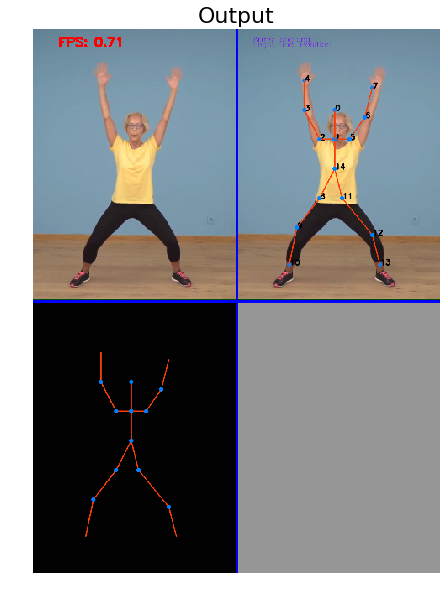

In [14]:
OpCV_Utils.show_single_image_plt(cv2.cvtColor(final_frame, cv2.COLOR_BGR2RGB), 'Output', fig_size = (10,10))